# <center>TP2 : <br/> k-plus proches voisins, analyse discriminante et régression logistique</center>
<center><img src="https://media.giphy.com/media/20NLMBm0BkUOwNljwv/giphy.gif" width="400" height="400"></center>

In [73]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import datasets
from sklearn import linear_model
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings

## Génération artificielle de données
On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les visualiser facilement) à savoir p = 2 dans le formalisme ci-dessus. On reprend en partie les jeux de données artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

## Question 1.
Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers générez 150 observations dans chaque classe ; pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1, 1).T, (−1, −1).T et (1, −1).T, tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [2]:
###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

def toPandas(rand):
    df = pd.DataFrame(rand[0], columns = ['X1', 'X2'])
    df['Label'] = rand[1]
    return df

def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

In [3]:
toPandas(rand_bi_gauss()).head(5)

,X1,X2,Label
0,-1.035334,-0.976907,-1.0
1,0.970505,0.981856,1.0
2,-0.983868,-0.908255,-1.0
3,0.993581,0.974110,1.0
4,-0.963577,-1.034341,-1.0


In [4]:
toPandas(rand_tri_gauss()).head(5)

,X1,X2,Label
0,-0.948688,-0.979441,2.0
1,1.017144,-0.934244,3.0
2,0.982204,-0.866290,3.0
3,0.940246,0.981832,1.0
4,1.167558,-0.822289,3.0


In [5]:
toPandas(rand_clown()).head(5)

,X1,X2,Label
0,0.758972,1.672381,1.0
1,0.691846,1.654860,1.0
2,3.155400,1.059458,-1.0
3,-0.597477,-0.404368,1.0
4,0.279746,1.867146,-1.0


In [6]:
toPandas(rand_checkers()).head(5)

,X1,X2,Label
0,0.409976,-0.667669,3.0
1,-1.479970,-0.308360,1.0
2,-1.071430,1.373231,3.0
3,-0.286875,1.817545,1.0
4,0.975866,-0.421466,3.0


On a des points (X1,X2) avec une observation dans la dernière colonne, pour chaque couple.

In [7]:
X1, Y1 = rand_bi_gauss()
X2, Y2 = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])
X3, Y3 = rand_clown()
X4, Y4 = rand_checkers(n1 = 150, n2 = 150)

## Question 2.
Utilisez la fonction plot_2d afin d’afficher les jeux de données générés avec chacune des fonctions

In [8]:
###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)[:]
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

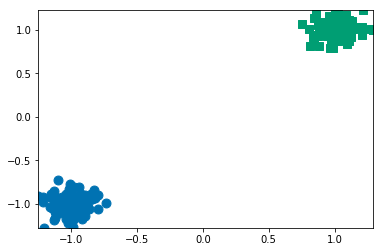

In [9]:
plot_2d(X1, Y1)

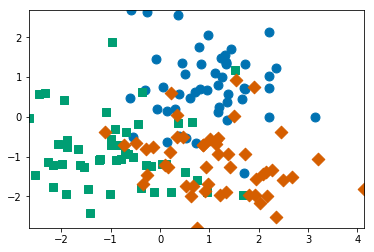

In [10]:
plot_2d(X2, Y2)

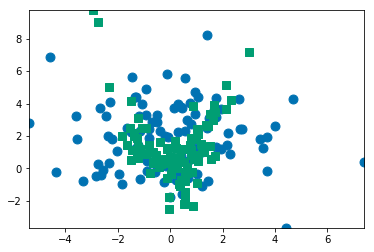

In [11]:
plot_2d(X3, Y3)

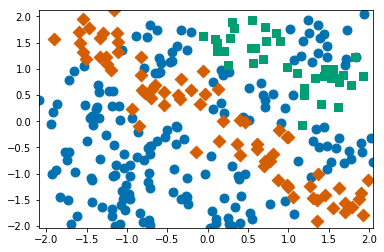

In [12]:
plot_2d(X4, Y4)

## Approche intuitive
L’algorithme des k-plus proches voisins (k-nn : pour k-nearest neighbors en anglais) est un algorithme intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque d’étiquettes. <br>
Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point x on commence par déterminer l’ensemble de ses k-plus proches voisins parmi les points d’apprentissage que l’on note Vk(x) (bien sûr on doit choisir 1 ≤ k ≤ n pour que cela ait un sens). La classe que l’on affecte au nouveau point x est alors la classe majoritaire dans l’ensemble Vk(x). Une illustration de la méthode est donnée en Figure 1 pour le cas de trois classes.

## Question 3.
Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y sont à valeurs réelles : Y = R.

Dans ce cas, au lieu de prendre la classe la plus présente, on prend la <strong>moyenne</strong> des k voisins

## Question 4.

Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans Vk(x). Vérifier la validité des résultats en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNNClassifier(BaseEstimator, ClassifierMixin):
    """Homemade kNN classifier class"""
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X_ = X
        self.Y_ = y
        return self

    def most_common(self, L):
        """ Returns the most common element of a list, randomly chosen if several elements """
        # Dict de présence
        dic = {}
        for e in L :
            if e in dic :
                dic[e]+=1
            else :
                dic[e] = 1
        maxima = [next(iter(dic.keys()))]
        # List of most common elements
        for e in dic :
            if dic[e] > dic[maxima[0]] :
                maxima = [e]
            elif dic[e] == dic[maxima[0]] :
                maxima.append(e)
        prediction = maxima[0]
        # If list is more than one element, random choice
        if len(maxima) > 1:
            prediction = random.sample(maxima, 1)[0]
        return prediction
    
    def predict(self, X):
        dist_matrix = metrics.pairwise.pairwise_distances(X,self.X_)
        neighbors = np.argsort(dist_matrix)[:,0:self.n_neighbors]
        labels = self.Y_[neighbors]
        return [self.most_common(label) for label in labels]

In [14]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1)

myKNN = KNNClassifier(n_neighbors=5)
myKNN.fit(X2_train,Y2_train)
y_pred_me = myKNN.predict(X2_test)

skLearnKNN = neighbors.KNeighborsClassifier(n_neighbors=5) 
skLearnKNN.fit(X2_train,Y2_train)
y_pred_skL = skLearnKNN.predict(X2_test)

y_pred_me == y_pred_skL

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

On remarque que les prédictions sont 'quasi' identiques. La différence s'explique par une randomisation sur les cas d'égalité, qui peut engendrer quelques différences avec le module de SKLearn (la randomisation n'est probablement pas identique)

## Question 5.

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique d(x, v) = || kx − vk2 || et k = 5. Visualisez les règles de classification obtenues en utilisant la fonction <i>frontiere_new</i>. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

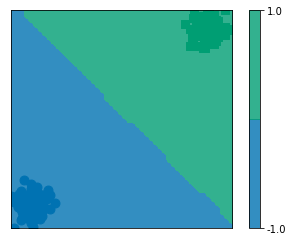

In [15]:
myKNN_1 = KNNClassifier(n_neighbors=5)
myKNN_1.fit(X1,Y1)

frontiere_new((lambda x : myKNN_1.predict(x.reshape(1,-1))), X1, Y1)

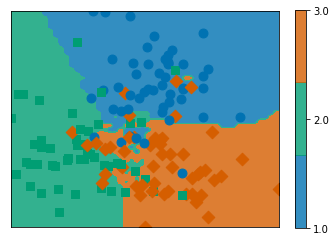

In [16]:
myKNN_2 = KNNClassifier(n_neighbors=5)
myKNN_2.fit(X2,Y2)

frontiere_new((lambda x : myKNN_2.predict(x.reshape(1,-1))), X2, Y2)

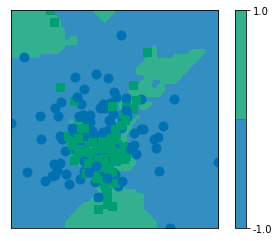

In [17]:
myKNN_3 = KNNClassifier(n_neighbors=5)
myKNN_3.fit(X3,Y3)

frontiere_new((lambda x : myKNN_3.predict(x.reshape(1,-1))), X3, Y3)

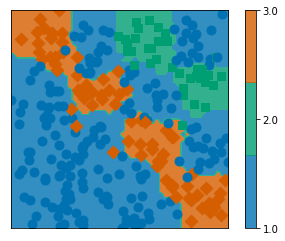

In [18]:
myKNN_4 = KNNClassifier(n_neighbors=5)
myKNN_4.fit(X4,Y4)

frontiere_new((lambda x : myKNN_4.predict(x.reshape(1,-1))), X4, Y4)

## Question 6.

Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris en compte : k = 1, 2, . . . , n. Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

In [19]:
X_train = X2[::2]
Y_train = Y2[::2]
X_test = X2[1::2]
Y_test = Y2[1::2]

### K = 1 

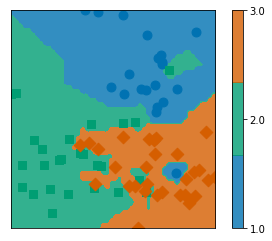

In [20]:
myKNN = KNNClassifier(n_neighbors=1)
myKNN.fit(X_train,Y_train)

frontiere_new((lambda x : myKNN.predict(x.reshape(1,-1))), X_train, Y_train)

### K = 5

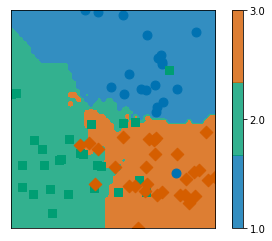

In [21]:
myKNN = KNNClassifier(n_neighbors=5)
myKNN.fit(X_train,Y_train)

frontiere_new((lambda x : myKNN.predict(x.reshape(1,-1))), X_train, Y_train)

### K = 10 

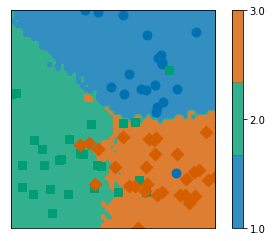

In [22]:
myKNN = KNNClassifier(n_neighbors=10)
myKNN.fit(X_train,Y_train)

frontiere_new((lambda x : myKNN.predict(x.reshape(1,-1))), X_train, Y_train)

### K = n 

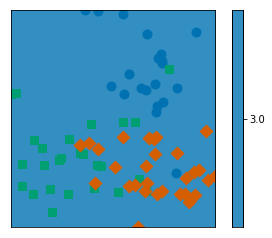

In [23]:
myKNN_2 = KNNClassifier(n_neighbors=len(X_train))
myKNN_2.fit(X_train,Y_train)

frontiere_new((lambda x : myKNN_2.predict(x.reshape(1,-1))), X_train, Y_train)

On se rend compte que : <br>
 - Lorsque k = 1 : la classification est 'trop' précise, la frontière est alors complèxe et correspond à un ensemble de petites régions <br>
 - Lorsque k = n : la classification est beaucoup trop vague. A chaque point on étudie l'ensemble des voisin : on classifie donc systématiquement à la classe la plus présente dans le dataset <br>

La frontière devient plus simple dans le cas où la classification prend en compte un nombre raisonnable de voisins, de manière à grouper par région des points. Ce nombre est fortement dépendant du dataset. Dans nos exemple, un nombre de voisin de l'ordre de [5 ; 10] semble être adapté
    
    

## Question 7.

Une variante possible très utilisée consiste à pondérer les poids du jème voisin (...). Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur de KNeighborsClassifier. Pour tester l’impact du choix de h sur les frontières de classification, visualisez les règles de classification pour k = 7 et h = 10**j avec j = −2, −1, 0, 1, 2 ; utilisez les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez utiliser la fonction frontiere_new.)

In [24]:
def _weight_func(dist, j):
    """ Weight function to replace lambda d: d ** -2.
    The lambda function is not valid because:
    if d==0 then 0^-2 is not valid. """

    # Dist could be multidimensional, flatten it so all values
    # can be looped
    with np.errstate(divide='ignore'):
        retval = 1. / dist
    return retval ** (-j)

### j = -2

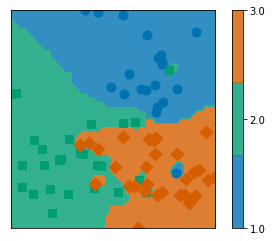

In [25]:
j = -2
KNN = neighbors.KNeighborsClassifier(n_neighbors=7, weights = (lambda x : _weight_func(x,j)))
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

### j = -1 

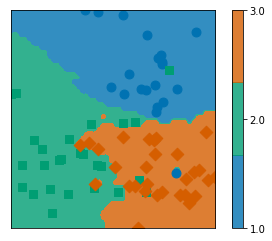

In [26]:
j = -1
KNN = neighbors.KNeighborsClassifier(n_neighbors=7, weights = (lambda x : _weight_func(x,j)))
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

### j = 0

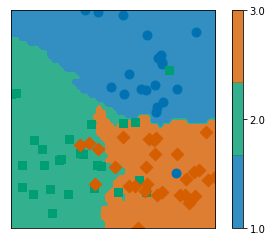

In [27]:
j = 0
KNN = neighbors.KNeighborsClassifier(n_neighbors=7, weights = (lambda x : _weight_func(x,j)))
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

### j = 1 

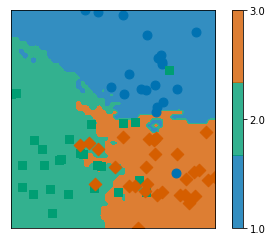

In [28]:
j = 1
KNN = neighbors.KNeighborsClassifier(n_neighbors=7, weights = (lambda x : _weight_func(x,j)))
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

### j = 2 

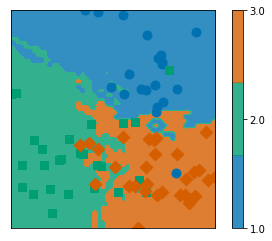

In [29]:
j = 2
KNN = neighbors.KNeighborsClassifier(n_neighbors=7, weights = (lambda x : _weight_func(x,j)))
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

## Question 8. 

Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [30]:
KNN = neighbors.KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

#### Sur données train

In [31]:
print(1 - KNN.score(X_train, Y_train))

0.0


#### Sur données test 

In [32]:
print(1 - KNN.score(X_test, Y_test))

0.3466666666666667


## Question 9.

Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50. Vous pourrez utiliser la classe fournie ErrorCurve.

In [33]:
X_train = X4[::2]
Y_train = Y4[::2]
X_test = X4[1::2]
Y_test = Y4[1::2]

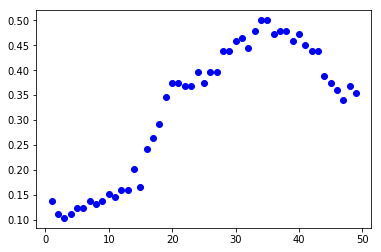

In [34]:
Errors = []
for k in range(1,50):
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,Y_train)
    Errors.append(1- KNN.score(X_test,Y_test))

plt.plot(range(1,50), Errors, 'bo')
plt.show()

## Question 10.

Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)

### n = 100

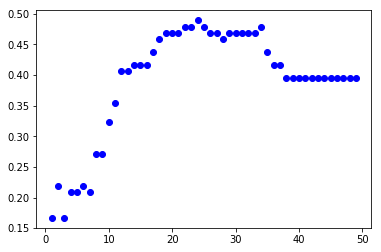

In [35]:
X4, Y4 = rand_checkers(n1 = 100, n2 = 100)

X_train = X4[::2]
Y_train = Y4[::2]
X_test = X4[1::2]
Y_test = Y4[1::2]

Errors = []
for k in range(1,50):
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,Y_train)
    Errors.append(1- KNN.score(X_test,Y_test))

plt.plot(range(1,50), Errors, 'bo')
plt.show()

Il semble que <strong>k entre [1,5]</strong> soient les valeurs les plus optimales pour k dans [1,50]. Du fait de la randomisation du dataset, les valeurs peuvent varier suivant les tirages

### n = 200 

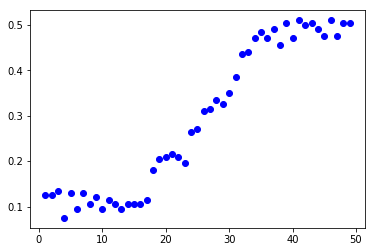

In [36]:
X4, Y4 = rand_checkers(n1 = 200, n2 = 200)

X_train = X4[::2]
Y_train = Y4[::2]
X_test = X4[1::2]
Y_test = Y4[1::2]

Errors = []
for k in range(1,50):
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,Y_train)
    Errors.append(1- KNN.score(X_test,Y_test))

plt.plot(range(1,50), Errors, 'bo')
plt.show()

Il semble que <strong>k autour de 10</strong> soient les valeurs les plus optimales pour k dans [1,50]. Du fait de la randomisation du dataset, les valeurs peuvent varier suivant les tirages

### n = 500 

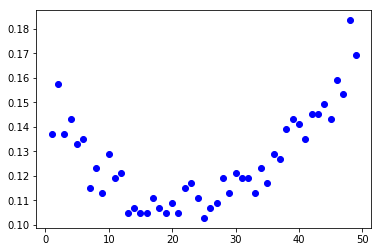

In [37]:
X4, Y4 = rand_checkers(n1 = 500, n2 = 500)

X_train = X4[::2]
Y_train = Y4[::2]
X_test = X4[1::2]
Y_test = Y4[1::2]

Errors = []
for k in range(1,50):
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,Y_train)
    Errors.append(1- KNN.score(X_test,Y_test))

plt.plot(range(1,50), Errors, 'bo')
plt.show()

Il semble que <strong>k autour de 20</strong> soient les valeurs les plus optimales pour k dans [1,50]. Du fait de la randomisation du dataset, les valeurs peuvent varier suivant les tirages. C'est encore plus visible pour un n plus grand, comme ici

### n = 1000

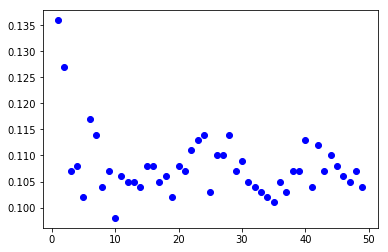

In [38]:
X4, Y4 = rand_checkers(n1 = 1000, n2 = 1000)

X_train = X4[::2]
Y_train = Y4[::2]
X_test = X4[1::2]
Y_test = Y4[1::2]

Errors = []
for k in range(1,50):
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,Y_train)
    Errors.append(1- KNN.score(X_test,Y_test))

plt.plot(range(1,50), Errors, 'bo')
plt.show()

Il semble que <strong>k entre [20,30]</strong> soient les valeurs les plus optimales pour k dans [1,50]. Du fait de la randomisation du dataset, les valeurs peuvent varier suivant les tirages. C'est particulièrement visible pour un n très grand, comme ici

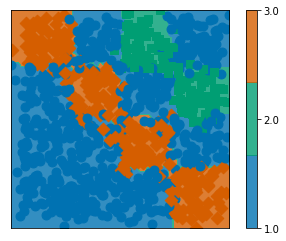

In [39]:
KNN = neighbors.KNeighborsClassifier(n_neighbors=25)
KNN.fit(X_train,Y_train)

frontiere_new((lambda x : KNN.predict(x.reshape(1,-1))), X_train, Y_train)

## Question 11.

A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins : temps de calcul ? passage à l’échelle ? interprétabilité ?

La méthode des plus proches voisins permet un temps de fit du modèle nul. L'interprétabilité est également assez facile et simple. Pour les petit jeux de données et à faible dimension, cette méthode semble particulièrement adaptée, notemment en première approche. <br>
Cependant, cette méthode peut devenir rapidement plus couteuse en temps de calcul pour les k grands lors du predict. Le passage à l'echelle semble donc plus compliqué

## Question 12.

Étudiez la base digits de scikit-learn : Décrivez la nature et le format des données (précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez le taux d’erreur.

In [40]:
digits = datasets.load_digits()
X = digits.data
Y = digits.target

df = pd.DataFrame(X)
df['Y'] = Y
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,Y
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


On a un X avec 64 colonnes décrivant le degré de noir des 64 pixels d'une image. Le Y donne le label, un chiffre de 0 à 9 que représente l'image.

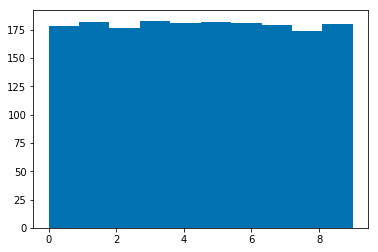

In [41]:
plt.hist(Y)
plt.show()

In [42]:
X_train = X[::2]
Y_train = Y[::2]
X_test = X[1::2]
Y_test = Y[1::2]

KNN = neighbors.KNeighborsClassifier(n_neighbors=30)
KNN.fit(X_train,Y_train)
print(1 - KNN.score(X_train,Y_train))

0.04004449388209119


## Question 13.

Estimez la matrice de confusion (P{Y = i, Ck(X) = j})i, j associée au classifieur Ck ainsi obtenu et visualisez celle-ci.

Confusion matrix, without normalization
[[88  0  0  0  0  0  0  0  0  0]
 [ 0 88  0  0  0  0  1  0  0  0]
 [ 1  1 84  0  0  0  0  1  4  0]
 [ 0  0  1 85  0  2  0  2  3  0]
 [ 0  0  0  0 87  0  0  0  1  0]
 [ 0  0  0  0  0 87  1  0  0  3]
 [ 0  0  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  0  0 91  0  0]
 [ 0  5  2  1  0  2  1  0 75  0]
 [ 0  5  0  0  5  1  0  6  1 73]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.01 0.01 0.92 0.   0.   0.   0.   0.01 0.04 0.  ]
 [0.   0.   0.01 0.91 0.   0.02 0.   0.02 0.03 0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.96 0.01 0.   0.   0.03]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.06 0.02 0.01 0.   0.02 0.01 0.   0.87 0.  ]
 [0.   0.05 0.   0.   0.05 0.01 0.   0.07 0.01 0.8 ]]


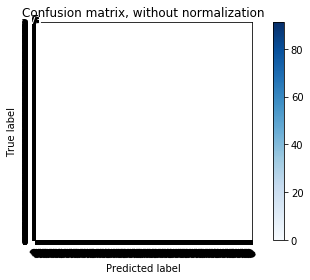

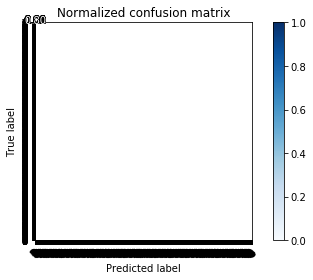

In [43]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = Y

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = KNN
y_pred = classifier.fit(X_train, Y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Question 14.

Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200.

In [58]:
list_of_k = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
Errors = []

for k in list_of_k :
    KNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    score_cumulee = 0
    for train_index, test_index in loo.split(X):
        KNN.fit(X[train_index], Y[train_index])
        score_cumulee += KNN.score(X[test_index], Y[test_index])
    Errors.append(1 - (score_cumulee/len(Y)))

print(Errors)        

[0.011686143572620988, 0.014468558708959356, 0.015581524763494725, 0.01947690595436835, 0.023372287145242088, 0.028380634390651083, 0.03227601558152471, 0.03283249860879245, 0.036727879799666074, 0.036727879799666074, 0.07011686143572626, 0.1012799109627156]


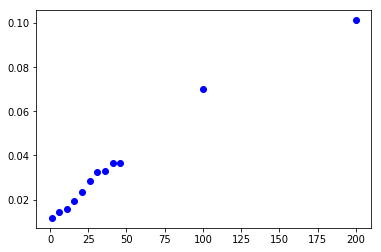

In [59]:
plt.plot(list_of_k, Errors, 'bo')
plt.show()

Il semble que plus k soit élevé, plus l'erreur est importante. Il faut donc prendre un <strong>k faible, entre 1 et 10</strong>

## Question 15.

En utilisant la formule de Bayes donner la formule des probabilités a posteriori : P{Y = +1 | X = x}, P{Y = −1 | X = x}, comme fonctions de f+, f− et π+.

<img src="https://drive.google.com/file/d/1qPXQIBD4-WgRfTKJT2GeG2uQpMiueYvI.jpeg">

## Question 16.

Exprimer le log-ratio des deux classes en fonction de π+, μ+, μ− et Σ.

## Question 17.

Justifier le choix du classifieur

## Question 18.

Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification predict.

<i><strong>Non traitée</strong></i>

## Question 19.

Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe <i>LinearDiscriminantAnalysis</i> de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m, i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez les taux d’erreur de LDAClassifier et de LinearDiscriminantAnalysis et le nombre de cas où les prédictions coïncident. En utilisant votre classe LDAClassifier, visualisez la règle de classification.

<i><strong>Non traitée</strong></i>

## Question 20.

En utilisant votre classe LDAClassifier, visualisez la règle de classification pour les jeux de données #1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode dans ces deux cas.

<strong>NOTE :</strong> Les 2 questions précédentes n'ayant pas été traitées, j'ai pris le classifier sklearn pour répondre à cette question

### X1

Score : 1.0


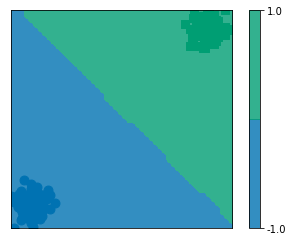

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.7, random_state=1)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)

print('Score : ' + str(lda.score(X_test, Y_test)))

frontiere_new((lambda x : myKNN_1.predict(x.reshape(1,-1))), X1, Y1)

Les données étant 'bien' séparées en 2 noyaux distincs, la séparation linéaire de la LDA est très performante

### X3 

Score : 0.6214285714285714


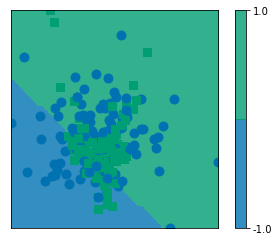

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.7, random_state=1)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)

print('Score : ' + str(lda.score(X_test, Y_test)))

frontiere_new((lambda x : myKNN_1.predict(x.reshape(1,-1))), X3, Y3)

Ici, les données des 2 classes sont mélangées sur cette représentation à 2 variable. On observe graphiquement qu'il n'est pas possible de séparer les 2 classes linéairement. Effectivement, dans ce cas, la LDA est très peu performante.

## Question 21.

Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

<i><strong>Non traitée</strong></i>

## Question 22.

À quoi correspond la variable coef_ du modèle ? intercept_ ?

<i><strong>Non traitée</strong></i>

## Question 23.

Utiliser la fonction frontiere_new pour visualiser la frontière de décision.

<i><strong>Non traitée</strong></i>

## Question 24. 

Appliquez la classification par régression logistique à des données issues de la base digits. Comme précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.

<i><strong>Non traitée</strong></i>